## Joint Thresholding in L1-Regularized Reconstruction

In this notebook, we investigate why the L1-regularized reconstruction in **BART** performs worse than in **Monalisa**. We focus on the *phantom* use case, which exhibits the most pronounced quality gap between the two methods.

We begin by running basic reconstructions to confirm that the issue does not originate from the raw data. Next, we examine the parameter `B`, referred to as the *joint thresholding flag*, which we initially hypothesized could be responsible for the observed image distortions.

Our experiments reveal that, regardless of the choice of `B` or regularization value, the reconstructed image quality never reaches a satisfactory level.


In [ ]:
# Functions are implemented in a helper file here we simply call them.
# I know is bad practice to import this way but is just a few functions (everything under control :D  )
from helpers import *

In [5]:
import subprocess

# phantom l1, l2, eye l1,l2, cardiac l1,l2 
prefix = 'phantom'

# Construct BART command for L1 or L2 regularization
output_path = f'./{prefix}_testsense'
bart_command = (
    f"./bart/bart pics "
    f"-t ./bart_data/traj_bart_{prefix} "
    f"-p ./bart_data/weights_bart_{prefix}_scaled "
    f"./bart_data/kspace_bart_{prefix} "
    f"./bart_data/C_bart_{prefix} "
    f"{output_path} "
)

# Execute BART command
try:
    subprocess.run(bart_command, shell=True, check=True)
except subprocess.CalledProcessError as e:
    print(f"Error running BART command for {prefix}: {e}")

# Read the reconstructed image
reconstructed = cfl.readcfl(output_path)

# Normalize the reconstruction within the specified ROI
print("BART reconstructions completed and saved successfully.")


[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 1.383751
BART reconstructions completed and saved successfully.


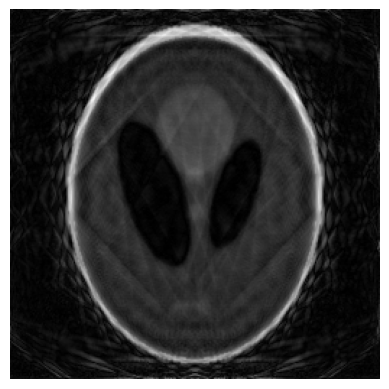

In [6]:
mag_recon = np.abs(reconstructed)

print('')
# If it's multi-coil or multi-frame, pick the first frame for display
plt.imshow(mag_recon, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
!./bart/bart pics -Rh

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R G:A:B:C	total generalized variation
-R C:A:B:C	infimal convolution TV
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.
-R TF:{graph_path}:lambda	TensorFlow loss


As you can see the l1-reg in the spatial domain is achieved with
-R I:B:C  	l1-norm in image domain
But what is B (is joint threshold flags?) ?? Could that be the reason why we see bad reconstruction quality for the Bart l1 reg?
The following analysis was our way to understand using the bart toolbox as a blackbox, if B is the reason we are having bad reconstruction quality

# First question: Does B have an impact on the reconstructed images: YES

In [19]:

import subprocess
import numpy as np

prefix = 'phantom'
n_iter = 140
regval = 0.000092367086

# Output paths
output_joint = f'./{prefix}_test_l1_joint'
output_sep   = f'./{prefix}_test_l1_sep'
output_sep2   = f'./{prefix}_test_l1_sep2'

# Joint thresholding (B=5) 
cmd_joint = (
    f"./bart/bart pics -R T:3:5:{regval} -i{n_iter} -m -u {10*regval} -C4 -t ./bart_data/traj_bart_{prefix} -p ./bart_data/weights_bart_{prefix}_scaled ./bart_data/kspace_bart_{prefix} ./bart_data/C_bart_{prefix} {output_joint}"
)

# Separate L1 (B=0)
cmd_sep = (
    f"./bart/bart pics -R T:3:0:{regval} -i{n_iter} -m -u {10*regval} -C4 -t ./bart_data/traj_bart_{prefix} -p ./bart_data/weights_bart_{prefix}_scaled ./bart_data/kspace_bart_{prefix} ./bart_data/C_bart_{prefix} {output_joint}"
)

# Separate2 L1 (B=0) just to check that the results are not random in any ways (same input => same output)
cmd_sep2 = (
    f"./bart/bart pics -R T:3:0:{regval} -i{n_iter} -m -u {10*regval} -C4 -t ./bart_data/traj_bart_{prefix} -p ./bart_data/weights_bart_{prefix}_scaled ./bart_data/kspace_bart_{prefix} ./bart_data/C_bart_{prefix} {output_joint}"
)

# Run both commands
subprocess.run(cmd_joint, shell=True, check=True)
subprocess.run(cmd_sep, shell=True, check=True)
subprocess.run(cmd_sep2, shell=True, check=True)

# Read images
reconstructed_joint = cfl.readcfl(output_joint)
reconstructed_sep   = cfl.readcfl(output_sep)
reconstructed_sep2   = cfl.readcfl(output_sep)

# Compare
diff_norm = np.linalg.norm(reconstructed_joint - reconstructed_sep)
rel_diff = diff_norm / np.linalg.norm(reconstructed_sep)

print(f"Absolute difference norm: {diff_norm}")
print(f"Relative difference: {rel_diff}")
print("Are different joint thresholding images identical?", np.allclose(reconstructed_joint, reconstructed_sep))


# Compare
diff_norm = np.linalg.norm(reconstructed_sep2 - reconstructed_sep)
rel_diff = diff_norm / np.linalg.norm(reconstructed_sep)

print(f"Absolute difference norm: {diff_norm}")
print(f"Relative difference: {rel_diff}")
print("Same input equal same output?", np.allclose(reconstructed_sep2, reconstructed_sep))


[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.215999
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.302837
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.377752
Absolute difference norm: 1.248246669769287
Relative difference: 0.13104963302612305
Are different joint thresholding images identical? False
Absolute difference norm: 0.0
Relative difference: 0.0
Same input equal same output? True


# Second step: By trying many different values of B we realized that only the two lowest bits of B matter. Only four different outcomes are possbile for B=0,1,2,3.

In [20]:
import subprocess
import numpy as np

prefix = 'phantom'
n_iter = 140
regval = 0.000092367086

# Ground truth load
gt = cfl.readcfl(f'./bart_data/image_bart_{prefix}')

def run_and_load(B_val):
    output = f'./{prefix}_test_l1_B{B_val}'
    cmd = (
        f"./bart/bart pics -R T:3:{B_val}:{regval} -i{n_iter} -m -u {10*regval} -C4 "
        f"-t ./bart_data/traj_bart_{prefix} "
        f"-p ./bart_data/weights_bart_{prefix}_scaled "
        f"./bart_data/kspace_bart_{prefix} "
        f"./bart_data/C_bart_{prefix} {output}"
    )
    subprocess.run(cmd, shell=True, check=True)
    return cfl.readcfl(output)

# Generate 15 random B values from 0 to 1000
np.random.seed(42)
B_values = np.random.randint(1, 1000, 15)

# Run and compare
results = {}
for B in B_values:
    print(f"Running B={B} ...")
    results[B] = run_and_load(B)

# Now compare
base = results[0] if 0 in results else None
if base is None:
    print("No B=0 run found, adding one for baseline.")
    base = run_and_load(0)
    results[0] = base

for B, img in results.items():
    if B == 0:
        continue
    diff = np.linalg.norm(np.abs(img - base))
    rel_diff = diff / np.linalg.norm(np.abs(base))
    print(f"B={B}: Relative difference to B=0 = {rel_diff:.6e}")
    assert rel_diff > 1e-12 or np.allclose(img, base, atol=1e-12), "Unexpected difference found!"

print("All nonzero B values give the same result, different from B=0.")


Running B=103 ...
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.166046
Running B=436 ...
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.231200
Running B=861 ...
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.240261
Running B=271 ...
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000092
Regularization terms: 1, Supporting variables: 0
ADMM
T

In [21]:
groups = {}
for B, img in results.items():
    if B == 0:
        continue
    diff = np.linalg.norm(np.abs(img - base))
    rel_diff = diff / np.linalg.norm(np.abs(base))
    key = round(rel_diff, 5)
    if key not in groups:
        groups[key] = []
    groups[key].append(B)

for k, vals in groups.items():
    print(f"Rel diff ~{k}: B values = {vals}")
    print("Binary flags:")
    for v in vals:
        print(f"{v}: {bin(v)}")
    print()


Rel diff ~0.03245000168681145: B values = [np.int64(103), np.int64(271), np.int64(107), np.int64(615), np.int64(467), np.int64(215), np.int64(331), np.int64(459)]
Binary flags:
103: 0b1100111
271: 0b100001111
107: 0b1101011
615: 0b1001100111
467: 0b111010011
215: 0b11010111
331: 0b101001011
459: 0b111001011

Rel diff ~0.0: B values = [np.int64(436), np.int64(72), np.int64(88)]
Binary flags:
436: 0b110110100
72: 0b1001000
88: 0b1011000

Rel diff ~0.03156000003218651: B values = [np.int64(861), np.int64(701), np.int64(21)]
Binary flags:
861: 0b1101011101
701: 0b1010111101
21: 0b10101

Rel diff ~0.031860001385211945: B values = [np.int64(122)]
Binary flags:
122: 0b1111010



# Interpretation:
| B (Joint trsh flag) | Relative diff | Interpretation        |
| ------------------- | ------------- | --------------------- |
| 0 (0b00)            | 0%            |   No thresholding     |
| 1 (0b01)            | 3.156%        |  dim1 thresholding    |
| 2 (0b10)            | 3.186%        |  dim2 thresholding    |
| 3 (0b11)            | 3.245%        |  dim1&2 thresholding  |

# LAST STEP
 Run many recons for different values of B, C (= reg val), and display the results. No significant improvement is visible. B=0 yields best resutlts.

Running for reg=3.16e-05 ...
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000032
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.232355
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000032
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.200202
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000032
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 344.317243
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
TV regularization: 0.000032
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 7.130478
Running for reg=5.22e

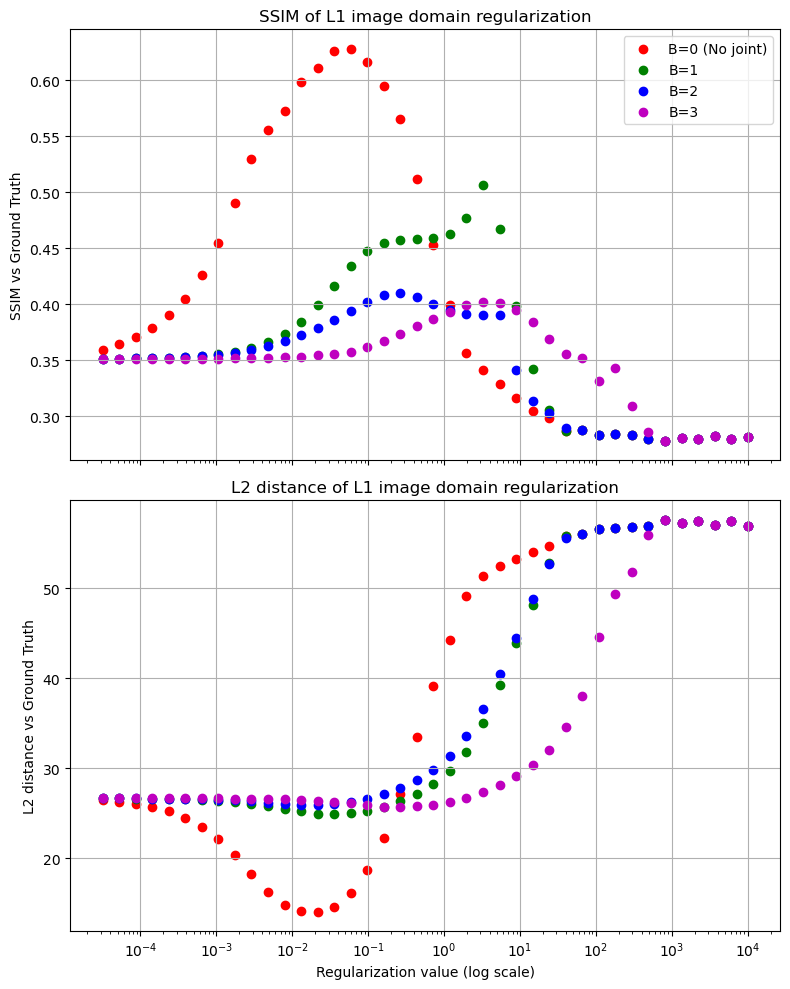

In [ ]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from skimage.metrics import structural_similarity as ssim

# ---------------------
# Parameters
# ---------------------
prefix = 'phantom'
n_iter = 140
Bs = [0, 1, 2, 3]
reg_vals = np.logspace(-4.5, 4, 40)  # Regularization values (log-spaced)

ellipse_params = {
    'center_x': 128,
    'center_y': 126,
    'major_axis': 89,
    'minor_axis': 118,
    'angle': 0
}

# ---------------------
# Load ground truth
# ---------------------
gt = cfl.readcfl(f'./bart_data/image_bart_{prefix}')

# Dimensionality check for GT
if gt.ndim != 2:
    raise ValueError(f"Ground truth image is {gt.ndim}D, expected 2D.")

# Normalized GT for consistency
gt_norm = normalize_within_roi(gt, gt, ellipse_params)

# ---------------------
# Results storage
# ---------------------
ssim_results = {b: [] for b in Bs}
l2_results = {b: [] for b in Bs}

# ---------------------
# Reconstruction loop
# ---------------------
for reg in reg_vals:
    print(f"Running for reg={reg:.2e} ...")
    for B in Bs:
        output_path = f'./{prefix}_I_{B}_reg_{reg:.2e}'
        cmd = (
            f"./bart/bart pics -R T:3:{B}:{reg} -i{n_iter} -m -u {10*reg} -C4 "
            f"-t ./bart_data/traj_bart_{prefix} "
            f"-p ./bart_data/weights_bart_{prefix}_scaled "
            f"./bart_data/kspace_bart_{prefix} "
            f"./bart_data/C_bart_{prefix} {output_path}"
        )
        subprocess.run(cmd, shell=True, check=True)

        # Load reconstruction
        recon = cfl.readcfl(output_path)

        # Dimensionality check for reconstruction
        if recon.ndim != 2:
            raise ValueError(f"Reconstruction output is {recon.ndim}D, expected 2D.")

        # ROI-based normalization
        recon_norm = normalize_within_roi(recon, gt_norm, ellipse_params)

        # Compute SSIM
        ssim_val = ssim(
            np.abs(gt_norm),
            np.abs(recon_norm),
            data_range=np.abs(gt_norm).max() - np.abs(gt_norm).min()
        )

        # Compute L2 distance (normalized)
        l2_val = np.linalg.norm(np.abs(gt_norm) - np.abs(recon_norm))

        # Store results
        ssim_results[B].append(ssim_val)
        l2_results[B].append(l2_val)

# ---------------------
# Plotting
# ---------------------
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

colors = {0: 'r', 1: 'g', 2: 'b', 3: 'm'}
labels = {0: 'B=0 (No joint)', 1: 'B=1', 2: 'B=2', 3: 'B=3'}

# SSIM plot
for B in Bs:
    axes[0].scatter(reg_vals, ssim_results[B], color=colors[B], label=labels[B])
axes[0].set_xscale('log')
axes[0].set_ylabel('SSIM vs Ground Truth')
axes[0].set_title('SSIM of L1 image domain regularization')
axes[0].grid(True)
axes[0].legend()

# L2 plot
for B in Bs:
    axes[1].scatter(reg_vals, l2_results[B], color=colors[B], label=labels[B])
axes[1].set_xscale('log')
axes[1].set_xlabel('Regularization value (log scale)')
axes[1].set_ylabel('L2 distance vs Ground Truth')
axes[1].set_title('L2 distance of L1 image domain regularization')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from skimage.metrics import structural_similarity as ssim

# ---------------------
# Parameters
# ---------------------
prefix = 'phantom'
n_iter = 140
Bs = [0, 1, 2, 3]
reg_vals = np.logspace(4.1, 5.5, 4)  # Regularization values (log-spaced)

ellipse_params = {
    'center_x': 128,
    'center_y': 126,
    'major_axis': 89,
    'minor_axis': 118,
    'angle': 0
}

# ---------------------
# Load ground truth
# ---------------------
gt = cfl.readcfl(f'./bart_data/image_bart_{prefix}')

# Dimensionality check for GT
if gt.ndim != 2:
    raise ValueError(f"Ground truth image is {gt.ndim}D, expected 2D.")

# Normalized GT for consistency
gt_norm = normalize_within_roi(gt, gt, ellipse_params)

# ---------------------
# Results storage
# ---------------------
ssim_results = {b: [] for b in Bs}
l2_results = {b: [] for b in Bs}

# ---------------------
# Reconstruction loop
# ---------------------
for reg in reg_vals:
    print(f"Running for reg={reg:.2e} ...")
    for B in Bs:
        output_path = f'./{prefix}_I_{B}_reg_{reg:.2e}'
        cmd = (
            f"./bart/bart pics -R T:3:{B}:{reg} -i{n_iter} -m -u {10*reg} -C4 "
            f"-t ./bart_data/traj_bart_{prefix} "
            f"-p ./bart_data/weights_bart_{prefix}_scaled "
            f"./bart_data/kspace_bart_{prefix} "
            f"./bart_data/C_bart_{prefix} {output_path}"
        )
        subprocess.run(cmd, shell=True, check=True)

        # Load reconstruction
        recon = cfl.readcfl(output_path)

        # Dimensionality check for reconstruction
        if recon.ndim != 2:
            raise ValueError(f"Reconstruction output is {recon.ndim}D, expected 2D.")

        # ROI-based normalization
        recon_norm = normalize_within_roi(recon, gt_norm, ellipse_params)

        # Compute SSIM
        ssim_val = ssim(
            np.abs(gt_norm),
            np.abs(recon_norm),
            data_range=np.abs(gt_norm).max() - np.abs(gt_norm).min()
        )

        # Compute L2 distance (normalized)
        l2_val = np.linalg.norm(np.abs(gt_norm) - np.abs(recon_norm))

        # Store results
        ssim_results[B].append(ssim_val)
        l2_results[B].append(l2_val)

# ---------------------
# Plotting
# ---------------------
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

colors = {0: 'r', 1: 'g', 2: 'b', 3: 'm'}
labels = {0: 'B=0 (No joint)', 1: 'B=1', 2: 'B=2', 3: 'B=3'}

# SSIM plot
for B in Bs:
    axes[0].scatter(reg_vals, ssim_results[B], color=colors[B], label=labels[B])
axes[0].set_xscale('log')
axes[0].set_ylabel('SSIM vs Ground Truth')
axes[0].set_title('SSIM of L1 image domain regularization')
axes[0].grid(True)
axes[0].legend()

# L2 plot
for B in Bs:
    axes[1].scatter(reg_vals, l2_results[B], color=colors[B], label=labels[B])
axes[1].set_xscale('log')
axes[1].set_xlabel('Regularization value (log scale)')
axes[1].set_ylabel('L2 distance vs Ground Truth')
axes[1].set_title('L2 distance of L1 image domain regularization')
axes[1].grid(True)

plt.tight_layout()
plt.show()

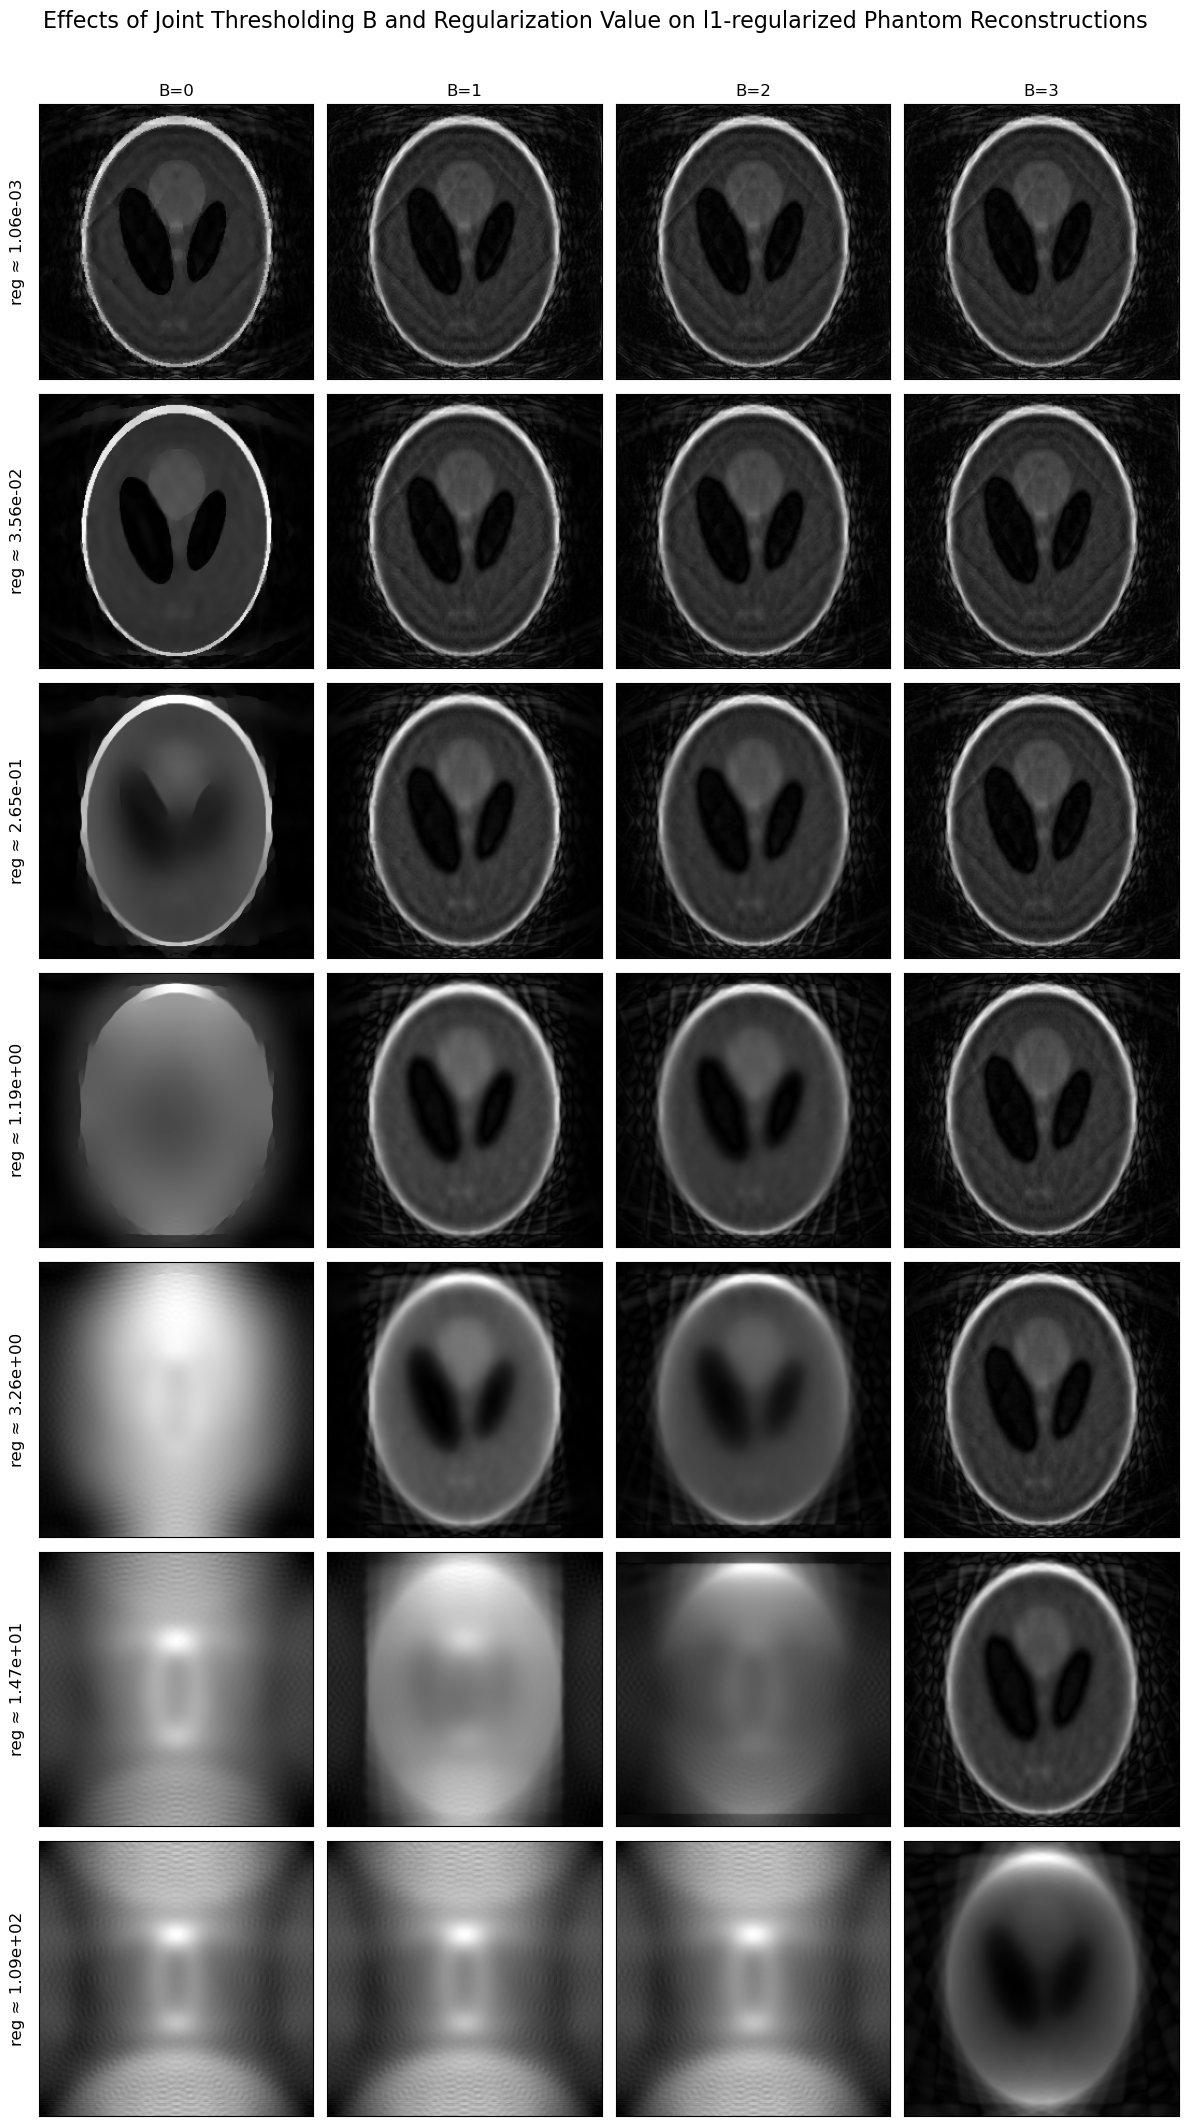

In [36]:
import matplotlib.pyplot as plt
ellipse_params = {
    'center_x': 128,
    'center_y': 126,
    'major_axis': 89,
    'minor_axis': 118,
    'angle': 0
}
gt = cfl.readcfl(f'./bart_data/image_bart_{prefix}')
# Normalized GT for consistency
gt_norm = normalize_within_roi(gt, gt, ellipse_params)
# Choose reg targets and find closest indices
Bs = [0, 1, 2, 3]

target_regs = [0.001, 0.03, 0.25, 1.2, 3, 15, 90 ]
reg_vals = np.logspace(-4.5, 4, 40)  # Regularization values (log-spaced)



chosen_reg_indices = [np.argmin(np.abs(reg_vals - t)) for t in target_regs]
chosen_regs = reg_vals[chosen_reg_indices]

# Store reconstructions for plotting
stored_recons = {B: {} for B in Bs}

for i, reg in enumerate(reg_vals):
    if i in chosen_reg_indices:
        for B in Bs:
            output_path = f'./{prefix}_I_{B}_reg_{reg:.2e}'
            recon = cfl.readcfl(output_path)
            if recon.ndim != 2:
                raise ValueError(f"Reconstruction output is {recon.ndim}D, expected 2D.")
            recon_norm = normalize_within_roi(recon, gt_norm, ellipse_params)
            stored_recons[B][reg] = np.abs(recon_norm)

fig, axes = plt.subplots(len(chosen_regs), len(Bs), figsize=(3*len(Bs), 3*len(chosen_regs)), squeeze=False)
# Main title
fig.suptitle("Effects of Joint Thresholding B and Regularization Value on l1-regularized Phantom Reconstructions", fontsize=16, y=1.01)

for row_idx, reg in enumerate(chosen_regs):
    # Compute normalization bounds for this row
    row_images = [stored_recons[B][reg] for B in Bs]
    row_min = min(abs(img).min() for img in row_images)
    row_max = max(abs(img).max() for img in row_images)*0.8

    for col_idx, B in enumerate(Bs):
        ax = axes[row_idx, col_idx]
        img = stored_recons[B][reg]
        ax.imshow(img, cmap='gray') #, vmin=row_min, vmax=row_max)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Column titles = B values
        if row_idx == 0:
            ax.set_title(f"B={B}", fontsize=12)
        
        # Row labels = reg values
        if col_idx == 0:
            ax.set_ylabel(f"reg ≈ {reg:.2e}", fontsize=12, rotation=90, labelpad=10)

plt.tight_layout()
plt.show()